Top 5 productos por valor total exportado (sin incluir 'total'):
soya       20896.3
otros      13331.1
castaña     3156.0
maderas     2208.8
joyería     2005.5
dtype: float64


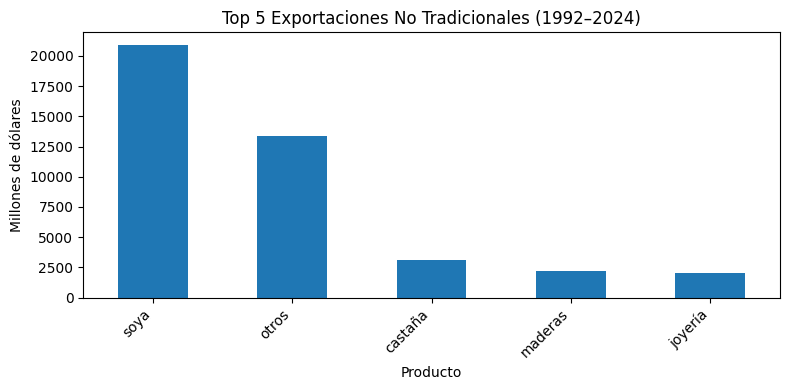

In [1]:
import pandas as pd
import sys
import matplotlib.pyplot as plt
import sqlite3, os
sys.path.append(os.path.abspath('../'))
from graficos_utils import (
    add_participation_cycle_boxes, add_cycle_means_multi, add_hitos,
    add_period_growth_annotations_multi, add_year_value_annotations
)

# ── 2. Carga de datos ────────────────────────────────────────────────
with sqlite3.connect("../../../../db/proyectomacro.db") as conn:
    df = pd.read_sql(
        "SELECT *FROM exportaciones_no_tradicionales",
        conn
    )
prod_cols = [c for c in df.columns if c not in ('año', 'total')]
totales = df.set_index('año')[prod_cols].sum().sort_values(ascending=False)

# Imprimimos top‐5
print("Top 5 productos por valor total exportado (sin incluir 'total'):")
print(totales.head(5))

# ── 4. Gráfica de los 5 principales ────────────────────────────────
fig, ax = plt.subplots(figsize=(8,4))
totales.head(5).plot.bar(ax=ax)
ax.set_title("Top 5 Exportaciones No Tradicionales (1992–2024)")
ax.set_ylabel("Millones de dólares")
ax.set_xlabel("Producto")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Ciclo Crisis 52-55 ignorado (fuera de rango)
Ciclo Expansión 56-69 ignorado (fuera de rango)
Ciclo Recesión 70-81 ignorado (fuera de rango)
Ciclo Crisis 82-84 ignorado (fuera de rango)


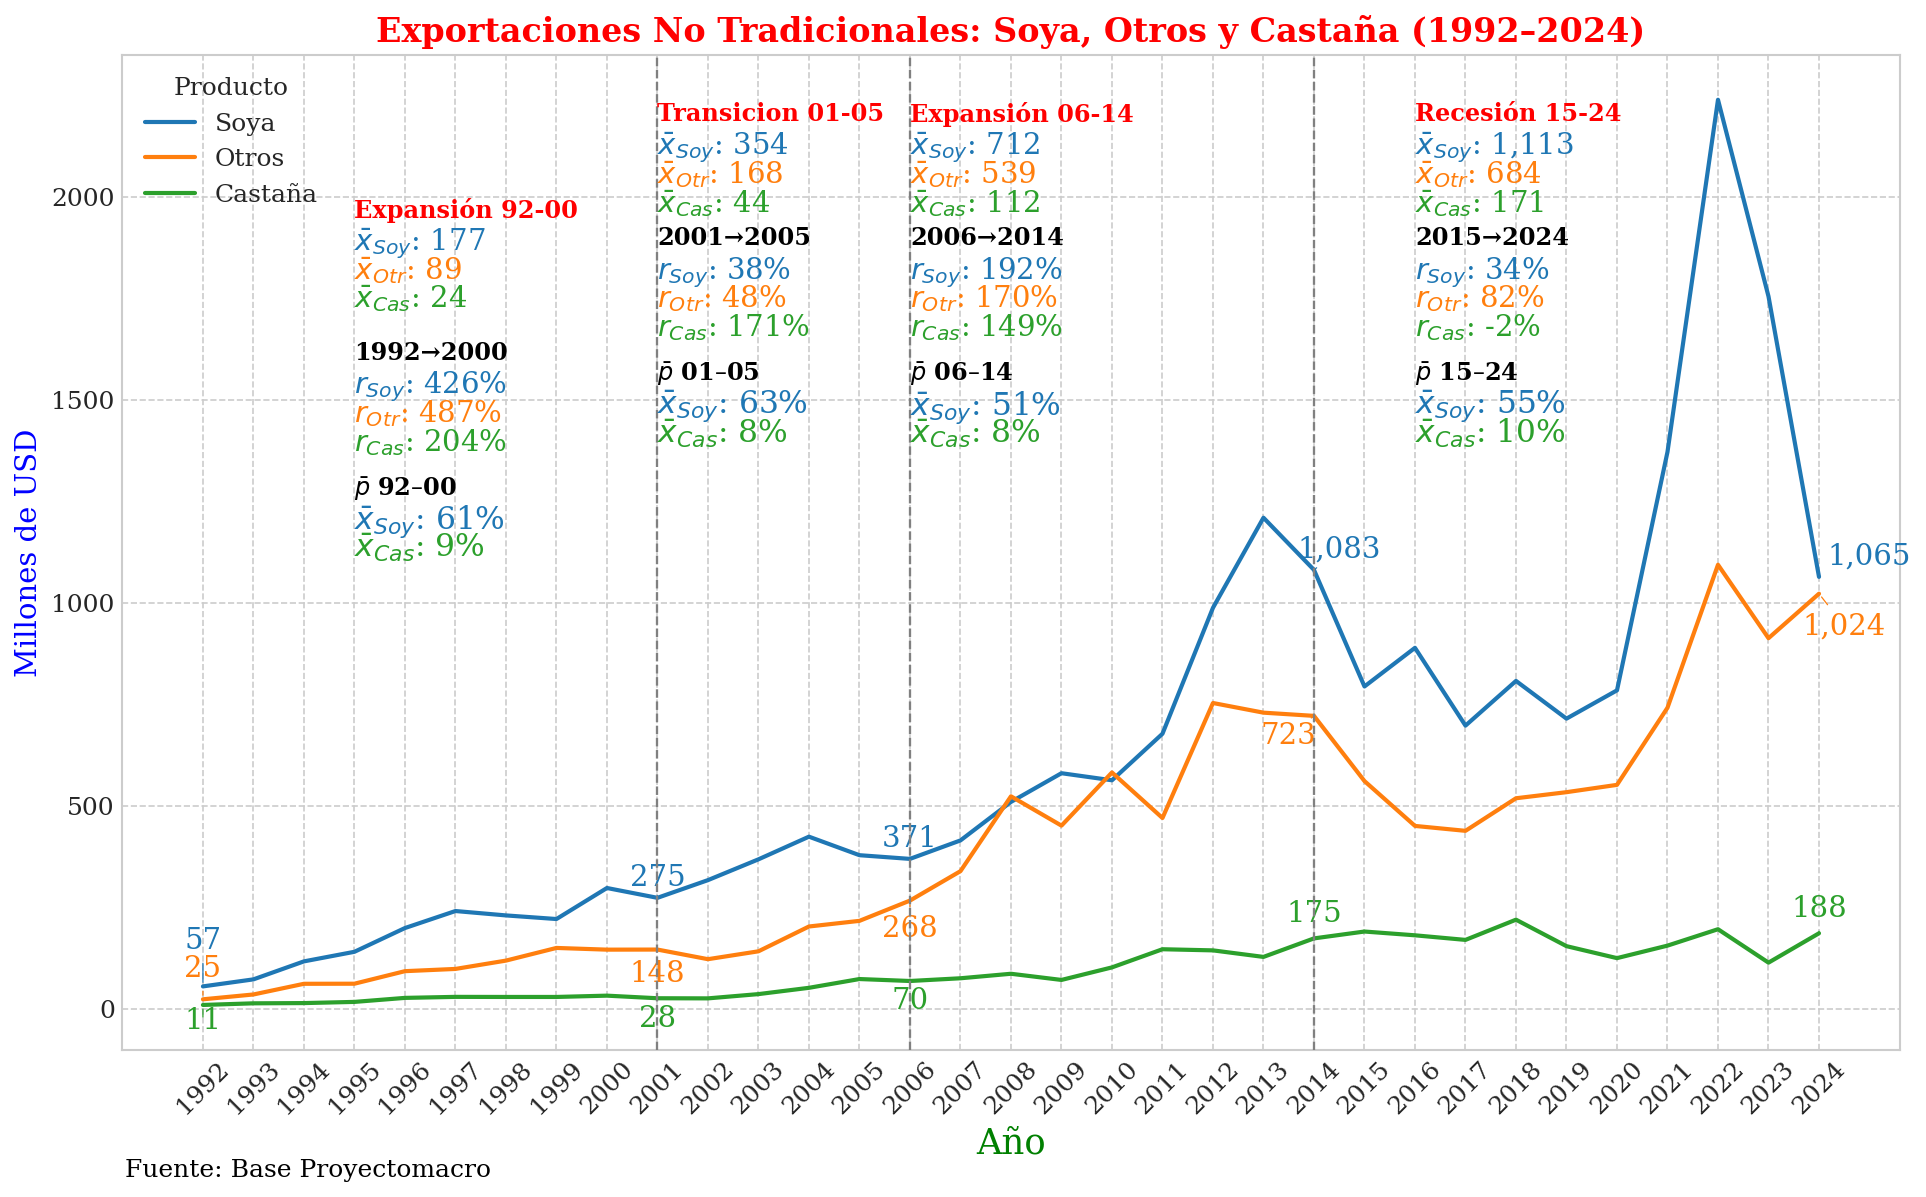

In [2]:
# ───────────────────────── 0. IMPORTS Y CONFIGURACIÓN GLOBAL ─────────────────────────
import os, sys, sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# utilidades propias
sys.path.append(os.path.abspath('../'))
from graficos_utils import *
from config import *          # CYCLES, hitos_v, annot_years, periodos_tasas …

OUTPUT_DIR = f"../../../../assets/tesis/serie_completa/exportaciones"
os.makedirs(OUTPUT_DIR, exist_ok=True)

set_style()                   # elimina rcParams manuales

# ───────────────────────────── 1. CARGA DE DATOS ─────────────────────────────
with sqlite3.connect("../../../../db/proyectomacro.db") as conn:
    df = (pd.read_sql("SELECT * FROM exportaciones_no_tradicionales",
                      conn, index_col="año")
            .sort_index())

df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
df['total'] = df[['soya', 'otros', 'castaña']].sum(axis=1)

# ──────────────── 2. DEFINICIÓN DE SERIES, COLORES Y ABREVIATURAS ────────────────
series = [
    ("soya",    "Soya"),
    ("otros",   "Otros"),
    ("castaña", "Castaña"),
]
cols_series = [c for c, _ in series]

cmap   = plt.get_cmap("tab10")
colors = {col: cmap(i) for i, (col, _) in enumerate(series)}
abbr   = {"soya": "Soy", "otros": "Otr", "castaña": "Cas"}

# ──────────────── 3. PREPARACIÓN DE CICLOS, ANOTACIONES Y PERÍODOS ────────────────
cycles       = adjust_cycles(df, CYCLES)
annot_years  = adjust_annot_years(df, annot_years)
periodos     = adjust_periods(df, periodos_tasas)
cycle_stats  = {name: df.loc[slc, cols_series].mean().to_dict()
                for name, slc in cycles.items()}

# ──────────────── 4. OFFSETS Y POSICIONAMIENTOS ────────────────
hitos_offsets = {año: 0.50 for año in hitos_v}

annotation_offsets = {
    "soya": {
        1992: (0, 112),
        2001: (0,  50),
        2006: (0,  50),
        2014: (0.5,50),
        2024: (1,  50),
    },
    "otros": {
        1992: (0,  75),
        2001: (0, -60),
        2006: (0, -70),
        2014: (-0.5, -50),
        2024: (0.5, -80),
    },
    "castaña": {
        1992: (0,  -40),
        2001: (0,  -50),
        2006: (0,  -50),
        2014: (0,   60),
        2024: (0,   60),
    },
}

medias_offsets = {
    "Expansión 92-00":  (1995, 0.85),
    "Transicion 01-05": (2001, 0.95),
    "Expansión 06-14":  (2006, 0.95),
    "Recesión 15-24":   (2016, 0.95),
}

tasas_offsets = {
    "1992-2000": (1995, 0.70),
    "2001-2005": (2001, 0.82),
    "2006-2014": (2006, 0.82),
    "2015-2024": (2016, 0.82),
}

participation_offsets = {
    "1992-2000": (1995, 0.56),
    "2001-2005": (2001, 0.68),
    "2006-2014": (2006, 0.68),
    "2015-2024": (2016, 0.68),
}

# ───────────────────────────── 5. GENERACIÓN DE LA GRÁFICA ─────────────────────────────
fig, ax = init_base_plot(
    df=df,
    series=series,
    colors=colors,
    title="Exportaciones No Tradicionales: Soya, Otros y Castaña (1992–2024)",
    xlabel="Año",
    ylabel="Millones de USD",
    source_text="Fuente: Base Proyectomacro",
)

add_hitos(ax, df.index, hitos_v, hitos_offsets)

line_spacing = ax.get_ylim()[1] * 0.03
add_cycle_means_multi(ax, cycle_stats, medias_offsets, abbr, colors, line_spacing)

add_year_value_annotations(ax, df, annot_years, cols_series,
                           annotation_offsets, colors, arrow_lw=0.6)

add_period_growth_annotations_multi(
    ax, df, periodos, cols_series, tasas_offsets, colors, abbr
)
add_participation_cycle_boxes(
    ax, df, periodos, ["soya","castaña"], "total",
    participation_offsets, abbr_map=abbr,
    colors={c: colors[c] for c in ["soya","castaña"]}
)

# ───────────────────────────── 6. AJUSTES FINALES Y EXPORTACIÓN ─────────────────────────────
ax.set_xticks(df.index[::max(1, len(df)//31)])
ax.tick_params(axis="x", rotation=45)
ax.legend(title="Producto", loc="upper left", fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "exportaciones_no_tradicionales_soya_otros_castaña.png"),
            dpi=300)
plt.show()
